## Выпускная квалификационная работа Яневица Рональда Бруновича
### студента группы 15702 курса "Data Science PRO" ЦДО МГТУ им. Н.Э. Баумана
#### Тема исследования "Прогнозирование конечных свойств новых материалов (композиционных материалов)".
## Часть 2
### 3. Создание нейронной сети, которая будет рекомендовать: 'Соотношение матрица-наполнитель'

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, max_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow import keras
from keras_tuner import RandomSearch
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Необходимо обучить алгоритм машинного обучения, который будет определять значения:
# 1. Модуль упругости при растяжении, ГПа;
# 2. Прочность при растяжении, МПа.
# При построении модели необходимо 30% данных оставить на тестирование модели, на остальных происходит обучение моделей. 
# При построении моделей провести поиск гиперпараметров модели с помощью поиска по сетке с перекрестной проверкой, 
# количество блоков равно 10.
# 
# Написать нейронную сеть, которая будет рекомендовать:
# 3. Соотношение матрица-наполнитель.
# 
# Таким образом, нам надо решить 3 задачи, для каждой надо создать входные данные, причём набор признаков 
# для каждой будет один, т.е. надо создать один массив Х и 3 массива Y.

cleaned_df = pd.read_excel("..\DATA\CleanedDataFrame.xlsx", index_col='Unnamed: 0')
cleaned_df['Угол нашивки'] = cleaned_df['Угол нашивки'].astype('category')
cleaned_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Плотность,813.0,NaN,NaN,NaN,1973.305080,69.536751,1801.940695,1923.566230,1976.800187,2019.065966,2150.793053
Модуль упругости,813.0,NaN,NaN,NaN,731.777187,326.047734,2.436909,496.873650,724.109184,951.030579,1588.677217
Количество отвердителя,813.0,NaN,NaN,NaN,111.346533,26.594886,41.886277,93.290977,111.259275,130.163998,181.828448
Содержание эпоксидных групп,813.0,NaN,NaN,NaN,22.143151,2.343374,15.881668,20.555344,22.130284,23.914238,28.620116
Температура вспышки,813.0,NaN,NaN,NaN,286.077341,39.538176,186.508613,258.370169,286.302097,313.046103,385.894771
Поверхностная плотность,813.0,NaN,NaN,NaN,480.130547,275.945272,0.603740,264.538975,453.919475,691.280873,1238.476416
Потребление смолы,813.0,NaN,NaN,NaN,217.511640,56.121929,72.530873,180.329055,217.481262,255.304191,359.052220
Угол нашивки,813.0,2.0,90.0,455.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Шаг нашивки,813.0,NaN,NaN,NaN,6.912574,2.473641,0.145034,5.167349,6.936649,8.582372,13.484945
Плотность нашивки,813.0,NaN,NaN,NaN,58.431672,9.194747,39.338977,51.690374,58.271705,64.798020,80.031619


In [5]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 813 entries, 1 to 1021
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Плотность                        813 non-null    float64 
 1   Модуль упругости                 813 non-null    float64 
 2   Количество отвердителя           813 non-null    float64 
 3   Содержание эпоксидных групп      813 non-null    float64 
 4   Температура вспышки              813 non-null    float64 
 5   Поверхностная плотность          813 non-null    float64 
 6   Потребление смолы                813 non-null    float64 
 7   Угол нашивки                     813 non-null    category
 8   Шаг нашивки                      813 non-null    float64 
 9   Плотность нашивки                813 non-null    float64 
 10  Соотношение матрица_наполнитель  813 non-null    float64 
 11  Прочность при растяжении         813 non-null    float64 
 12  Модуль упруг

In [6]:
# Из очищенного от выбросов датасета создаём один массив признаков Х и 3 массива целевых переменных Y.

X_columns = [
  'Плотность', 
  'Модуль упругости',
  'Количество отвердителя', 
  'Содержание эпоксидных групп',
  'Температура вспышки', 
  'Поверхностная плотность',
  'Потребление смолы', 
  'Угол нашивки',
  'Шаг нашивки', 
  'Плотность нашивки'
]

y1_columns = ['Прочность при растяжении']
y2_columns = ['Модуль упругости при растяжении']
y3_columns = ['Соотношение матрица_наполнитель']

X = cleaned_df.loc[:, X_columns]
y1 = cleaned_df.loc[:, y1_columns]
y2 = cleaned_df.loc[:, y2_columns]
y3 = cleaned_df.loc[:, y3_columns]


In [7]:
print(X.info())
print("=" * 70)
print(y1.info())
print("=" * 70)
print(y2.info())
print("=" * 70)
print(y3.info())

<class 'pandas.core.frame.DataFrame'>
Index: 813 entries, 1 to 1021
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Плотность                    813 non-null    float64 
 1   Модуль упругости             813 non-null    float64 
 2   Количество отвердителя       813 non-null    float64 
 3   Содержание эпоксидных групп  813 non-null    float64 
 4   Температура вспышки          813 non-null    float64 
 5   Поверхностная плотность      813 non-null    float64 
 6   Потребление смолы            813 non-null    float64 
 7   Угол нашивки                 813 non-null    category
 8   Шаг нашивки                  813 non-null    float64 
 9   Плотность нашивки            813 non-null    float64 
dtypes: category(1), float64(9)
memory usage: 64.4 KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 813 entries, 1 to 1021
Data columns (total 1 columns):
 #   Column                    N

Trial 40 Complete [00h 00m 13s]
val_mae: 0.7731140851974487

Best val_mae So Far: 0.7211333513259888
Total elapsed time: 00h 09m 34s
Лучшие гиперпараметры:
{'num_layers': 3, 'units_0': 224, 'activation_0': 'elu', 'dropout_0': 0.30000000000000004, 'units_1': 256, 'activation_1': 'tanh', 'dropout_1': 0.5, 'units_2': 160, 'activation_2': 'elu', 'dropout_2': 0.2, 'optimizer': 'adam', 'learning_rate': 0.0007878587857071874, 'units_3': 224, 'activation_3': 'relu', 'dropout_3': 0.30000000000000004, 'units_4': 128, 'activation_4': 'tanh', 'dropout_4': 0.30000000000000004}
Test MAE: 0.7211
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Метрики качества на тестовой выборке:
R2: 0.015
Max Error: 2.6
MSE: 0.8
RMSE: 0.9
MAE: 0.7
MAPE: 0.32%


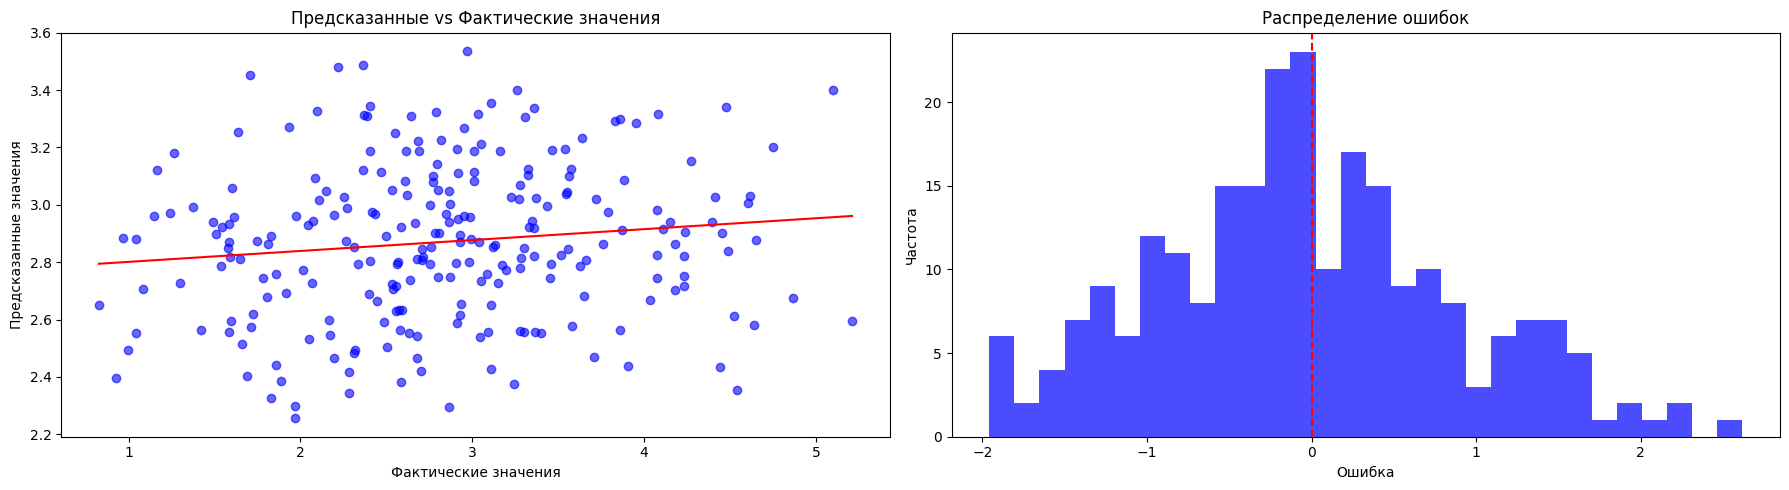

In [ ]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y3_train, y3_test = train_test_split(X, y3, test_size=0.3, random_state=1101)

# Определение числовых и категориальных столбцов
numeric_features = X.select_dtypes(include=['float64']).columns
categorical_features = X.select_dtypes(include=['category']).columns

# Создание преобразователей для числовых и категориальных данных
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

# Объединение преобразований в ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Применение предобработки
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Зададим автоматический подбор архитектуры нейронной сети. 
# 1. Определение функции построения модели (HyperModel)
def build_model(hp):
    model = keras.Sequential()
    
    # Настройка числа слоев
    num_layers = hp.Int('num_layers', min_value=1, max_value=5, default=3)
    
    # Первый скрытый слой
    model.add(layers.Dense(
        units=hp.Int('units_0', min_value=32, max_value=256, step=32),
        activation=hp.Choice('activation_0', ['relu', 'tanh', 'elu']),
        input_shape=[X_train_processed.shape[1]]
    ))
    model.add(layers.Dropout(
        rate=hp.Float('dropout_0', min_value=0.1, max_value=0.5, step=0.1)
    ))
    
    # Последующие скрытые слои
    for i in range(1, num_layers):
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            activation=hp.Choice(f'activation_{i}', ['relu', 'tanh', 'elu'])
        ))
        model.add(layers.Dropout(
            rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)
        ))
    
    # Выходной слой для регрессии
    model.add(layers.Dense(1))
    
    # Настройка оптимизатора и скорости обучения
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    
    if optimizer_choice == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=lr)
    elif optimizer_choice == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=lr)
    else:
        optimizer = keras.optimizers.SGD(learning_rate=lr)
        
    model.compile(
        optimizer=optimizer,
        loss='mae',
        metrics=['mae']
    )
    return model
 
# 2. Инициализация тюнера
tuner = RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=40,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='my_regression_project'
)

# Зададим ранний останов
callback1 = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max', min_delta=0.001,
    patience = 5)

# 3. Запуск поиска
tuner.search(
    X_train_processed, y3_train,
    epochs=100,
    validation_data=(X_test_processed, y3_test),
    callbacks=[callback1],
    batch_size=128,
    verbose=1
)
 
# 4. Получение лучшей модели
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
 
print("Лучшие гиперпараметры:")
print(best_hyperparameters.values)
 
# Оценка модели на тестовых данных
test_loss, test_mae = best_model.evaluate(X_test_processed, y3_test, verbose=0)
print(f"Test MAE: {test_mae:.4f}")
 
# Предсказание на новых данных
y_pred = best_model.predict(X_test_processed)

# Вычисление метрик качества
r2 = r2_score(y3_test, y_pred) * -1
max_err = max_error(y3_test, y_pred)
mse = mean_squared_error(y3_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y3_test, y_pred)
mape = mean_absolute_percentage_error(y3_test, y_pred)

# Создание датафрейма с метриками
metrics_NeuralNetwork = pd.DataFrame({
    'Метрика': ['R2', 'Max Error', 'MSE', 'RMSE', 'MAE', 'MAPE (%)'],
    'Значение LinearRegression': [r2, max_err, mse, rmse, mae, mape]
})

# Вывод метрик качества
print("\nМетрики качества на тестовой выборке:")
print(f"R2: {r2:.3f}")
print(f"Max Error: {max_err:.1f}")
print(f"MSE: {mse:.1f}")
print(f"RMSE: {rmse:.1f}")
print(f"MAE: {mae:.1f}")
print(f"MAPE: {mape:.2f}%")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

coefficients = np.polyfit(y3_test.squeeze(), y_pred.squeeze(), 1)
slope = coefficients[0]
intercept = coefficients[1]
regression_line_x = np.linspace(min(y3_test.squeeze()), max(y3_test.squeeze()), 100)
regression_line_y = slope * regression_line_x + intercept

# Кросс-плот между предсказанным и фактическим значением по лучшей модели
axes[0].scatter(y3_test, y_pred, alpha=0.6, color='Blue')
axes[0].plot(regression_line_x, regression_line_y, color='red')
axes[0].set_xlabel('Фактические значения')
axes[0].set_ylabel('Предсказанные значения')
axes[0].set_title('Предсказанные vs Фактические значения')

# Распределение ошибок по лучшей модели
errors = y3_test - y_pred
axes[1].hist(errors, bins=30, alpha=0.7, color='Blue')
axes[1].axvline(x=0, color='r', linestyle='--')
axes[1].set_xlabel('Ошибка')
axes[1].set_ylabel('Частота')
axes[1].set_title('Распределение ошибок')
 
plt.tight_layout()
plt.show()

In [9]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 224)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        57,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 160)            │        41,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,569 (396.75 KB)

 Trainable params: 101,569 (396.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Сохраним модель в файл
best_model.save('NN_Sequental_model_3.keras')